# ARIMA training
- This is an auto-generated notebook.
- To reproduce these results, attach this notebook to a cluster with runtime version **15.4.x-cpu-ml-scala2.12**, and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/2548317818374064).
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "value"
time_col = "ts"
unit = "month"

id_cols = ["cdid"]

horizon = 12

## Load Data

In [0]:
import mlflow
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
input_data_path = mlflow.artifacts.download_artifacts(run_id="e6204ffe8f404eb497e9926026c252ef", artifact_path="data", dst_path=input_temp_dir)

input_file_path = os.path.join(input_data_path, "training_data")
input_file_path = "file://" + input_file_path
df_loaded = ps.from_pandas(pd.read_parquet(input_file_path))


# Preview data
display(df_loaded.head(5))

ts,value,cdid
1988-01-01T00:00:00Z,48.4,D7BT
1988-02-01T00:00:00Z,48.6,D7BT
1988-03-01T00:00:00Z,48.7,D7BT
1988-04-01T00:00:00Z,49.3,D7BT
1988-05-01T00:00:00Z,49.5,D7BT


## Aggregate data by `id_col` and `time_col`
Group the data by `id_col` and `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col] + id_cols

df_aggregated = df_loaded \
  .groupby(group_cols) \
  .agg(y=(target_col, "avg")) \
  .reset_index()

df_aggregated = df_aggregated.assign(ts_id=lambda x:x["cdid"].astype(str))


display(df_aggregated.head(5))

ts,cdid,y,ts_id
1991-02-01T00:00:00Z,D7F5,39.8,D7F5
2020-01-01T00:00:00Z,D7BU,104.1,D7BU
1993-03-01T00:00:00Z,D7F5,46.0,D7F5
2021-12-01T00:00:00Z,D7BU,107.1,D7BU
1993-09-01T00:00:00Z,D7F5,47.4,D7F5


## Train ARIMA model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2548317818374064)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

In [0]:
# Define the search space of seasonal period m
seasonal_periods = [1, 3]

In [0]:
from pyspark.sql.types import *

df_schema = df_aggregated.to_spark().schema
result_columns = id_cols + ["pickled_model", "start_time", "end_time", "mse",
                  "rmse", "mae", "mape", "mdape", "smape", "coverage"]
result_schema = StructType(
  [StructField(id_col, df_schema[id_col].dataType) for id_col in id_cols] + [
  StructField("pickled_model", BinaryType()),
  StructField("start_time", TimestampType()),
  StructField("end_time", TimestampType()),
  StructField("mse", FloatType()),
  StructField("rmse", FloatType()),
  StructField("mae", FloatType()),
  StructField("mape", FloatType()),
  StructField("mdape", FloatType()),
  StructField("smape", FloatType()),
  StructField("coverage", FloatType())
  ])

def arima_training(history_pd):
  from databricks.automl_runtime.forecast.pmdarima.training import ArimaEstimator

  single_seasonal_period = history_pd["seasonal_periods"].iloc[0]
  seasonal_period_list = [single_seasonal_period]
  history_pd = history_pd.drop("seasonal_periods", axis=1)
 
  arima_estim = ArimaEstimator(horizon=horizon,
                               frequency_unit=unit,
                               metric="smape",
                               seasonal_periods=seasonal_period_list,
                               num_folds=5)

  results_pd = arima_estim.fit(history_pd)
  results_pd[id_cols] = history_pd[id_cols]
  results_pd["start_time"] = pd.Timestamp(history_pd["ds"].min())
  results_pd["end_time"] = pd.Timestamp(history_pd["ds"].max())
 
  return results_pd[result_columns]

def train_with_fail_safe(df):
  try:
    return arima_training(df)
  except Exception as e:
    print(f"Encountered an exception while training timeseries: {repr(e)}")
    return pd.DataFrame(columns=result_columns)

In [0]:
import mlflow
from databricks.automl_runtime.forecast.pmdarima.model import MultiSeriesArimaModel, mlflow_arima_log_model
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col, explode, array, lit

with mlflow.start_run(experiment_id="2548317818374064", run_name="Arima") as mlflow_run:
  mlflow.set_tag("estimator_name", "ARIMA")

  df_aggregated = df_aggregated.rename(columns={time_col: "ds"})

  windowSpec = Window.partitionBy(id_cols).orderBy(col("smape").asc())
  ts_id_count = df_aggregated["ts_id"].nunique()
  arima_results = (df_aggregated.to_spark().repartition(ts_id_count, "ts_id") \
    .withColumn("seasonal_periods", explode(array([lit(x) for x in seasonal_periods]))) \
    .groupby("ts_id", "seasonal_periods").applyInPandas(train_with_fail_safe, result_schema) \
      .withColumn("metric_rank", row_number().over(windowSpec)) \
      .filter(col("metric_rank") == 1).drop("metric_rank")).cache().pandas_api()
  arima_results = arima_results.to_pandas()
  arima_results["ts_id"] = arima_results[id_cols].astype(str).agg('-'.join, axis=1)
  arima_results["ts_id_tuple"] = arima_results[id_cols].apply(tuple, axis=1)
   
  # Check whether every time series's model is trained
  ts_models_trained = set(arima_results["ts_id"].unique().tolist())
  ts_ids = set(df_aggregated["ts_id"].unique().tolist())

  if len(ts_models_trained) == 0:
    raise Exception("Trial unable to train models for any identities. Please check the training cell for error details")

  if ts_ids != ts_models_trained:
    mlflow.log_param("partial_model", True)
    print(f"WARNING: Models not trained for the following identities: {ts_ids.difference(ts_models_trained)}")
 
  # Log metrics to mlflow
  metric_name_map = {"mse": "mean_squared_error", "rmse": "root_mean_squared_error", "mae": "mean_absolute_error",
                     "mape": "mean_absolute_percentage_error", "mdape": "mdape", "smape": "smape", "coverage": "coverage"}
  avg_metrics = arima_results[metric_name_map.keys()].rename(columns=metric_name_map).mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Save the model to mlflow
  arima_results = arima_results.set_index("ts_id_tuple")
  pickled_model = arima_results["pickled_model"].to_dict()
  start_time = arima_results["start_time"].to_dict()
  end_time = arima_results["end_time"].to_dict()
  arima_model = MultiSeriesArimaModel(pickled_model, horizon, unit, start_time, end_time, time_col, id_cols)

  # Generate sample input dataframe
  sample_input = df_loaded.tail(5).to_pandas()
  sample_input[time_col] = pd.to_datetime(sample_input[time_col])
  sample_input.drop(columns=[target_col], inplace=True)

  mlflow_arima_log_model(arima_model, sample_input=sample_input)

/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/databricks/python/lib/python3.11/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:392: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  preds_df = df.groupby(self._id_cols).apply(self._predict_single_id).reset_index(drop=True)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
avg_metrics

,mean_metrics
index,
val_mean_squared_error,7.518009
val_root_mean_squared_error,2.239981
val_mean_absolute_error,2.054427
val_mean_absolute_percentage_error,0.016594
val_mdape,0.016233
val_smape,0.016605
val_coverage,0.475926


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

In [0]:
future_df = loaded_model._model_impl.python_model.make_future_dataframe()

In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

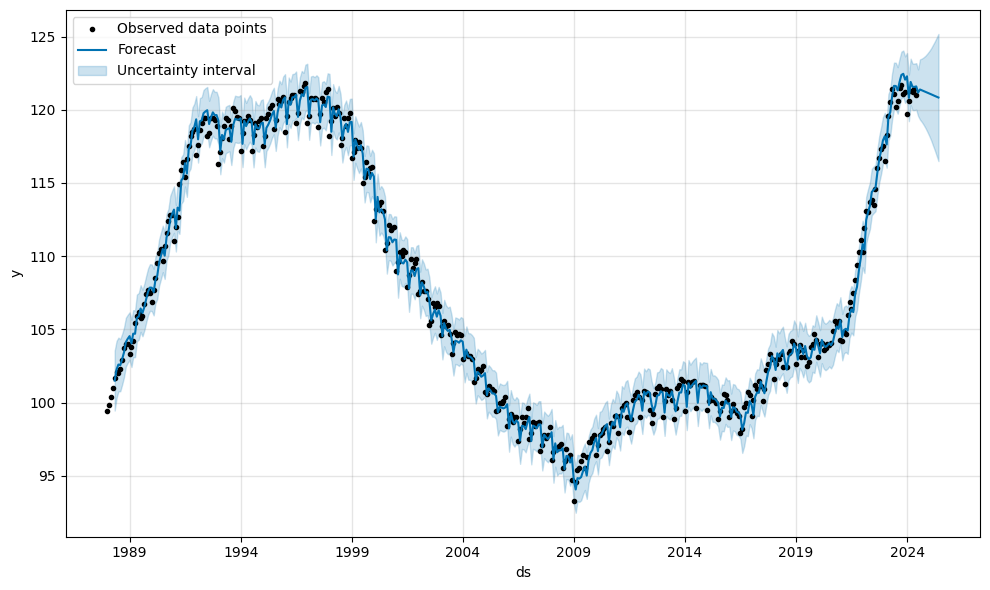

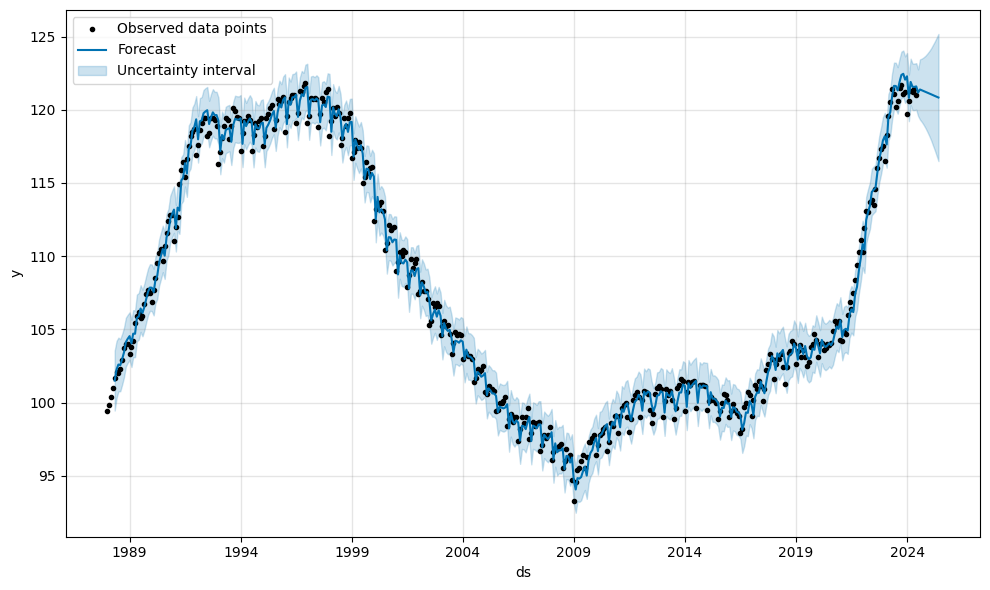

In [0]:
from databricks.automl_runtime.forecast.pmdarima.utils import plot

# Choose a random id from `ts_id` for plot
forecast_pd["ts_id"] = forecast_pd[id_cols].astype(str).agg('-'.join, axis=1)
forecast_pd["ts_id_tuple"] = forecast_pd[id_cols].apply(tuple, axis=1)
id_ = set(forecast_pd.index.to_list()).pop()
ts_id = forecast_pd["ts_id"].loc[id_]
ts_id_tuple = forecast_pd["ts_id_tuple"].loc[id_]
forecast_pd_plot = forecast_pd[forecast_pd["ts_id"] == ts_id]
history_pd_plot = df_aggregated[df_aggregated["ts_id"] == ts_id].to_pandas()
# When visualizing, we ignore the first d (differencing order) points of the prediction results
# because it is impossible for ARIMA to predict the first d values
d = loaded_model._model_impl.python_model.model(ts_id_tuple).order[1]
fig = plot(history_pd_plot[d:], forecast_pd_plot[d:])
fig

## Show the predicted results

In [0]:
predict_cols = id_cols + ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].tail(horizon))

cdid,ds,yhat
DKC6,2024-07-01T00:00:00Z,130.65140591131674
DKC6,2024-08-01T00:00:00Z,131.2900243371571
DKC6,2024-09-01T00:00:00Z,131.93189699679627
DKC6,2024-10-01T00:00:00Z,132.61978784309156
DKC6,2024-11-01T00:00:00Z,133.02340916128782
DKC6,2024-12-01T00:00:00Z,133.49026246122196
DKC6,2025-01-01T00:00:00Z,133.31686413237287
DKC6,2025-02-01T00:00:00Z,133.96808846828222
DKC6,2025-03-01T00:00:00Z,134.60679823161755
DKC6,2025-04-01T00:00:00Z,135.30001274476723
